In [1]:
import os 
import opendssdirect as dss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
import networkx as nx
import pandapower as pp
import pandapower.networks as pn

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV
import math
import pytensor
import pickle
import copy
import random

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\generated_data'

prob_3_phases=pickle.load(open(os.path.join(to_save_folder,'prob_3_phases.pickle'),'rb'))

phases_proportion=pickle.load(open(os.path.join(to_save_folder,'phases_proportion.pickle'),'rb'))

phases_planning=pickle.load(open(os.path.join(to_save_folder,'phases_planning.pickle'),'rb'))

power_df=pickle.load(open(os.path.join(to_save_folder,'power_df.pickle'),'rb'))

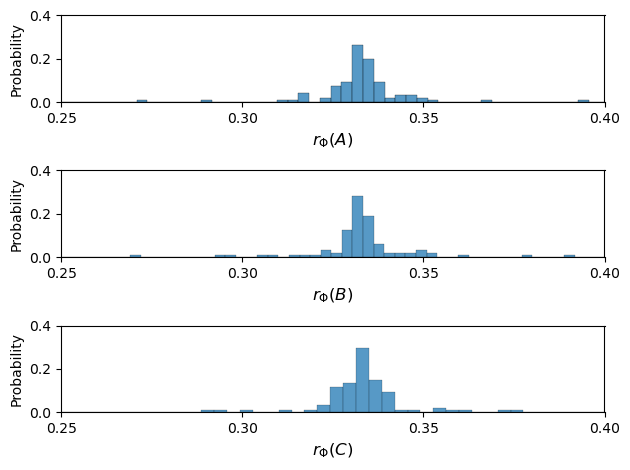

In [28]:
ratio_list=[[],[],[]]
for i in range(len(phases_planning)):
    partial_sum=sum(phases_planning[i])
    if(partial_sum!=0):
        ratio_list[0].append(phases_planning[i][0]/partial_sum)
        ratio_list[1].append(phases_planning[i][1]/partial_sum)
        ratio_list[2].append(phases_planning[i][2]/partial_sum)


fig, axs = plt.subplots(3,1)

sns.histplot(ratio_list[0],ax=axs[0],stat='probability')
axs[0].set_ylim([0,0.4])
axs[0].set_xlim([0.25,0.4])
axs[0].set_xticks([0.25,0.3,0.35,0.4])
axs[0].set_xlabel(r'$r_{\Phi}(A)$',size=12)

sns.histplot(ratio_list[1],ax=axs[1],stat='probability')
axs[1].set_ylim([0,0.4])
axs[1].set_xlim([0.25,0.4])
axs[1].set_xticks([0.25,0.3,0.35,0.4])
axs[1].set_xlabel(r'$r_{\Phi}(B)$',size=12)

sns.histplot(ratio_list[2],ax=axs[2],stat='probability')
axs[2].set_ylim([0,0.4])
axs[2].set_xlim([0.25,0.4])
axs[2].set_xticks([0.25,0.3,0.35,0.4])
axs[2].set_xlabel(r'$r_{\Phi}(C)$',size=12)

plt.tight_layout()


In [38]:
for j in range(len(ratio_list)):
    print(sum([i==0 for i in ratio_list[j]])/len(ratio_list[0]))

0.010526315789473684
0.010526315789473684
0.0


In [45]:
ar_phases_proportion=np.array(phases_proportion)
print(np.mean(ar_phases_proportion[:,0]))
print(np.mean(ar_phases_proportion[:,1]))
print(1-np.mean(ar_phases_proportion[:,0])-np.mean(ar_phases_proportion[:,1]))

0.32493101041666667
0.32964221875
0.3454267708333333


In [3]:
#num_single_loads
#num_three_phase_loads
#phases_planning
#phases_proportion

def generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice):
    with pm.Model() as three_phase_model:
        feeder_idx=0


        # proportion of each phase
        num_total_loads=len(graph_from_net.nodes)
        #num_total_loads=5
        #num_total_loads=int(num_single_loads[feeder_idx]+num_three_phase_loads[feeder_idx])
        #prop_three_phase=num_three_phase_loads[feeder_idx]/num_total_loads
        prob_three_phases_data=list(prob_three_phases_dict.values())
        #prob_three_phase=0

        three_phase_choice=pm.Bernoulli('three_phase_choice',p=prob_three_phases_data,shape=num_total_loads)



        mu_prop_a=np.mean([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
        #var_prop_a=np.std([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
        #prop_a=pm.TruncatedNormal('prop_a',mu=mu_prop_a,sigma=var_prop_a,shape=num_total_loads,lower=0)

        mu_prop_b=np.mean([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
        #var_prop_b=np.std([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
        #prop_b=pm.TruncatedNormal('prop_b',mu=mu_prop_b,sigma=var_prop_b,shape=num_total_loads,lower=0)

        mu_prop_c=np.mean([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
        #var_prop_c=np.std([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
        #prop_c=pm.TruncatedNormal('prop_c',mu=mu_prop_c,sigma=var_prop_c,shape=num_total_loads,lower=0)

        # phase choice


        phase_choice=pm.Categorical('phase_choice',p=p_phases_choice,shape=(num_total_loads))


        # defining load of each phase
        #mu_p_a=np.mean([phases_planning[idx][0] for idx in range(len(phases_planning))])
        mu_p_a=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][0] for idx in range(len(phases_planning))]/max([phases_planning[idx][0] for idx in range(len(phases_planning))])
        var_p_a=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_a=pm.Deterministic('mu_p_a',mu_p_a/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_a))) #phase a
        p_a=pm.TruncatedNormal('P_a',mu=mu_p_a,sigma=var_p_a,lower=0,shape=(num_total_loads))

        #mu_p_b=np.mean([phases_planning[idx][1] for idx in range(len(phases_planning))])
        mu_p_b=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][1] for idx in range(len(phases_planning))]/max([phases_planning[idx][1] for idx in range(len(phases_planning))])
        var_p_b=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_b=pm.Deterministic('mu_p_b',mu_p_b/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_b))) #phase b
        p_b=pm.TruncatedNormal('P_b',mu=mu_p_b,sigma=var_p_b,lower=0,shape=(num_total_loads))

        #mu_p_c=np.mean([phases_planning[idx][2] for idx in range(len(phases_planning))])
        mu_p_c=np.array(list(aggregated_power_dict.values()))
        normalizing_constant=[phases_planning[idx][2] for idx in range(len(phases_planning))]/max([phases_planning[idx][2] for idx in range(len(phases_planning))])
        var_p_c=np.std(normalizing_constant*np.max(list(aggregated_power_dict.values())))
        #expected_p_c=pm.Deterministic('mu_p_c',mu_p_c/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_c))) #phase c
        p_c=pm.TruncatedNormal('P_c',mu=mu_p_c,sigma=var_p_c,lower=0,shape=(num_total_loads))


        real_p_a=pm.Deterministic('real_p_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),p_a,0),p_a*mu_prop_a))
        real_p_b=pm.Deterministic('real_p_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),p_b,0),p_b*mu_prop_b))
        real_p_c=pm.Deterministic('real_p_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),p_c,0),p_c*mu_prop_c))



        power_factor_mu=0.95
        power_factor=pm.Beta('power_factor',mu=power_factor_mu,sigma=power_factor_mu*0.05,shape=num_total_loads)

        var_q_a=np.sqrt((var_p_a/power_factor_mu)**2-var_p_a**2)
        var_q_b=np.sqrt((var_p_b/power_factor_mu)**2-var_p_b**2)
        var_q_c=np.sqrt((var_p_c/power_factor_mu)**2-var_p_c**2)

        q_a=pm.TruncatedNormal('Q_a',mu=np.sqrt((mu_p_a/power_factor_mu)**2-mu_p_a**2),sigma=var_q_a,lower=0,shape=(num_total_loads))
        q_b=pm.TruncatedNormal('Q_b',mu=np.sqrt((mu_p_b/power_factor_mu)**2-mu_p_b**2),sigma=var_q_b,lower=0,shape=(num_total_loads))
        q_c=pm.TruncatedNormal('Q_c',mu=np.sqrt((mu_p_c/power_factor_mu)**2-mu_p_c**2),sigma=var_q_c,lower=0,shape=(num_total_loads))

        real_q_a=pm.Deterministic('real_q_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),q_a,0),q_a*mu_prop_a))
        real_q_b=pm.Deterministic('real_q_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),q_b,0),q_b*mu_prop_b))
        real_q_c=pm.Deterministic('real_q_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),q_c,0),q_c*mu_prop_c))

        #phases_planning[feeder_idx]
        #active_power_load=pm.Normal(mu=)
    return three_phase_model

# Sensitivity analysis


In [4]:
net=pn.ieee_european_lv_asymmetric() #simulated network: a real 3-phase system found in the pandapower library
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False)

# defining x and y coordinates for each bus

x_dict={}
y_dict={}

for bus_idx in net.bus.index:
    x_dict[bus_idx]=net.bus_geodata.at[bus_idx,'x']
    y_dict[bus_idx]=net.bus_geodata.at[bus_idx,'y']

nx.set_node_attributes(graph_from_net,x_dict,'x')
nx.set_node_attributes(graph_from_net,y_dict,'y')


# defining the x and y for the gen
bus_gen=0
x_gen=net.bus_geodata.at[bus_gen,'x']
y_gen=net.bus_geodata.at[bus_gen,'y']

#calculating max distance (from a given node to feeder)

max_distance=0
for node in graph_from_net.nodes:
    x=graph_from_net.nodes[node]['x']
    y=graph_from_net.nodes[node]['y']
    distance=np.sqrt((x-x_gen)**2+(y-y_gen)**2)
    if(distance>max_distance):
        max_distance=distance


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anacon

# Probability of being 3 phase based on distance

In [5]:
phases_line_list=[]
priori_prop_three_phase_dict={}
normalized_dist_dict={}
node_list=list(graph_from_net.nodes)
node_list.sort()


for u,v in graph_from_net.edges():
    x_line=graph_from_net.nodes[v]['x']
    y_line=graph_from_net.nodes[v]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    #print(normalized_dist)
    

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])

    random_number=np.random.rand() #random for line
    if(random_number<=individual_prob_list[0]):
        phases_line_list.append(1)
    elif(random_number<=individual_prob_list[1]):
        phases_line_list.append(2)
    else:
        phases_line_list.append(3)

for u in node_list:
    x_line=graph_from_net.nodes[u]['x']
    y_line=graph_from_net.nodes[u]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    normalized_dist_dict[u]=normalized_dist
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    #individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])


    priori_prop_three_phase_dict[u]=prob_3_phases[3][rounded_dist]

# Probability dicts and lists

In [6]:
individual_aggregated_power=1000*(np.mean(net.asymmetric_load[net.asymmetric_load.p_a_mw!=0].p_a_mw)+np.mean(net.asymmetric_load[net.asymmetric_load.p_b_mw!=0].p_b_mw)+np.mean(net.asymmetric_load[net.asymmetric_load.p_c_mw!=0].p_c_mw))

individual_aggregated_power=1000*(np.mean(net.asymmetric_load.p_a_mw+net.asymmetric_load.p_b_mw+net.asymmetric_load.p_c_mw))

node_list=list(graph_from_net.nodes)
node_list.sort()

aggregated_power_dict={}
phases_proportion=np.zeros(shape=(len(node_list),3))
p_phases_choice=np.zeros(shape=(len(node_list),3))
prob_three_phases_dict={}





for bus in node_list:
    aggregated_power_dict[bus]=individual_aggregated_power
    phases_proportion[bus][:]=[1/3,1/3,1/3]
    p_phases_choice[bus][:]=[1/3,1/3,1/3]
    prob_three_phases_dict[bus]=priori_prop_three_phase_dict[bus]

In [7]:
def generate_power_data_df(three_phase_model):
    with three_phase_model:
        idata = pm.sample(draws=100,chains=4,tune=10)


    #generating df_dict
    [num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

    sample_idx=0

    df_dict={}

    load_list_a=[[] for k_idx in range(num_loads)]
    load_list_b=[[] for k_idx in range(num_loads)]
    load_list_c=[[] for k_idx in range(num_loads)]

    df_dict=pd.DataFrame(columns=['sample_idx','node','p_a','q_a','p_b','q_b','p_c','q_c','num_phases','distance'])
    real_p_a_array=copy.deepcopy(idata.posterior['real_p_a'].values)
    real_p_b_array=copy.deepcopy(idata.posterior['real_p_b'].values)
    real_p_c_array=copy.deepcopy(idata.posterior['real_p_c'].values)
    real_q_a_array=copy.deepcopy(idata.posterior['real_q_a'].values)
    real_q_b_array=copy.deepcopy(idata.posterior['real_q_b'].values)
    real_q_c_array=copy.deepcopy(idata.posterior['real_q_c'].values)
    three_phase_choice_array=copy.deepcopy(idata.posterior['three_phase_choice'].values)


    for i in range(4): #chains
        print(i)
        for j in range(num_samples): #samples
            for k in range(num_loads):
                distance=normalized_dist_dict[k]
                phase_a_p=float(real_p_a_array[i][j][k])
                phase_a_q=float(real_q_a_array[i][j][k])
                phase_b_p=float(real_p_b_array[i][j][k])
                phase_b_q=float(real_q_b_array[i][j][k])
                phase_c_p=float(real_p_c_array[i][j][k])
                phase_c_q=float(real_q_c_array[i][j][k])
                num_phases=float(three_phase_choice_array[i][j][k])
                df_dict.loc[len(df_dict)]=[sample_idx,k,phase_a_p,phase_a_q,phase_b_p,phase_b_q,phase_c_p,phase_c_q,num_phases,distance]
        
            sample_idx+=1

    user_input_p=[]
    user_input_q=[]
    power_data_df=pd.DataFrame(columns=['source','power_type','phase','value'])
    error_dict={'p_a':[],
                'p_b':[],
                'p_c':[],
                'q_a':[],
                'q_b':[],
                'q_c':[],
                }


    user_input_p_a_list=[]
    for node_idx in graph_from_net.nodes:
        p_a=np.mean(df_dict[(df_dict.node==node_idx)].p_a)
        q_a=np.mean(df_dict[(df_dict.node==node_idx)].q_a)
        p_b=np.mean(df_dict[(df_dict.node==node_idx)].p_b)
        q_b=np.mean(df_dict[(df_dict.node==node_idx)].q_b)
        p_c=np.mean(df_dict[(df_dict.node==node_idx)].p_c)
        q_c=np.mean(df_dict[(df_dict.node==node_idx)].q_c)

        user_input_p_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_a_mw)
        user_input_p_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_b_mw)
        user_input_p_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].p_c_mw)
        user_input_q_a=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_a_mvar)
        user_input_q_b=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_b_mvar)
        user_input_q_c=1000*sum(net.asymmetric_load[net.asymmetric_load.bus==node_idx].q_c_mvar)

        #real data
        power_data_df.loc[len(power_data_df)]=['model','p','a',p_a]
        power_data_df.loc[len(power_data_df)]=['model','q','b',q_a]
        power_data_df.loc[len(power_data_df)]=['model','p','c',p_b]
        power_data_df.loc[len(power_data_df)]=['model','q','a',q_b]
        power_data_df.loc[len(power_data_df)]=['model','p','b',p_c]
        power_data_df.loc[len(power_data_df)]=['model','q','c',q_c]


        
        #user input
        if(user_input_p_a!=0):
            user_input_p_a_list.append(user_input_p_a)
            error_dict['p_a'].append(np.abs(((p_a-user_input_p_a)/user_input_p_a)))
            power_data_df.loc[len(power_data_df)]=['user_input','p','a',user_input_p_a]
        if(user_input_p_b!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','p','b',user_input_p_b]
            error_dict['p_b'].append(np.abs(((p_b-user_input_p_b)/user_input_p_b)))
        if(user_input_p_c!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','p','c',user_input_p_c]
            error_dict['p_c'].append(np.abs(((p_c-user_input_p_c)/user_input_p_c)))
        if(user_input_q_a!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','a',user_input_q_a]
            error_dict['q_a'].append(np.abs(((q_a-user_input_q_a)/user_input_q_a)))
        if(user_input_q_b!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','b',user_input_q_b]
            error_dict['q_b'].append(np.abs(((q_b-user_input_q_b)/user_input_q_b)))
        if(user_input_q_c!=0):
            power_data_df.loc[len(power_data_df)]=['user_input','q','c',user_input_q_c]
            error_dict['q_c'].append(np.abs(((q_c-user_input_q_c)/user_input_q_c)))

    return [power_data_df,error_dict]


## Sensitivity analysis 1 - p_three_phase

In [32]:
p_three_phase_list=[0.1,0.4,0.7,1.0]
mean_error_dict={}
power_data_df_dict={}

for p_three_phase in p_three_phase_list:
    print('######################## {} #####################'.format(p_three_phase))
    mean_error_dict[p_three_phase]={}
    for bus in node_list:
        aggregated_power_dict[bus]=individual_aggregated_power
        phases_proportion[bus][:]=[1/3,1/3,1/3]
        p_phases_choice[bus][:]=[1/3,1/3,1/3]
        #prob_three_phases_dict[bus]=priori_prop_three_phase_dict[bus]
        prob_three_phases_dict[bus]=p_three_phase

    three_phase_model=generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice)

    [power_data_df,error_dict]=generate_power_data_df(three_phase_model)

    for key in error_dict.keys():
        mean_error_dict[p_three_phase][key]=np.mean(error_dict[key])
        power_data_df_dict[p_three_phase]=copy.deepcopy(power_data_df)




######################## 0.1 #####################


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 301 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


0
1
2
3
######################## 0.4 #####################


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 145 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


Only 100 samples in chain.


######################## 0.7 #####################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 275 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3
######################## 1.0 #####################


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 206 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


In [7]:
import pickle

to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\results\changing_p_three_phase'

#pickle.dump(mean_error_dict,open(os.path.join(to_save_folder,'mean_error_dict.pickle'),'wb'))

#pickle.dump(power_data_df_dict,open(os.path.join(to_save_folder,'power_data_df_dict.pickle'),'wb'))


mean_error_dict=pickle.load(open(os.path.join(to_save_folder,'mean_error_dict.pickle'),'rb'))

power_data_df_dict=pickle.load(open(os.path.join(to_save_folder,'power_data_df_dict.pickle'),'rb'))

In [22]:
power_data_df=power_data_df_dict[0.1]
sensitivity_analysis_df=pd.DataFrame(columns=['prob_3','power_type','phase','real','simulated','error'])

for p_three in power_data_df_dict.keys():
    power_data_df=power_data_df_dict[p_three]
    for power_type in ['p']:
        for phase in ['a','b','c']:
            model=np.mean(power_data_df[(power_data_df.power_type==power_type) & (power_data_df.phase==phase) & (power_data_df.source=='model')].value)
            user_input=np.mean(power_data_df[(power_data_df.power_type==power_type) & (power_data_df.phase==phase) & (power_data_df.source=='user_input')].value)
            error=10*np.abs((model-user_input)/user_input)
            sensitivity_analysis_df.loc[len(sensitivity_analysis_df)]=[p_three,power_type,phase,user_input,model,error]
sensitivity_analysis_df

,prob_3,power_type,phase,real,simulated,error
0,0.1,p,a,0.830286,0.347633,5.813088
1,0.1,p,b,1.773579,0.347958,8.038101
2,0.1,p,c,0.414933,0.347531,1.624416
3,0.4,p,a,0.830286,0.347494,5.814772
4,0.4,p,b,1.773579,0.347391,8.041300
5,0.4,p,c,0.414933,0.347847,1.616796
6,0.7,p,a,0.830286,0.348126,5.807151
7,0.7,p,b,1.773579,0.347611,8.040060
8,0.7,p,c,0.414933,0.347206,1.632241
9,1.0,p,a,0.830286,0.347732,5.811897


# Sensitivity analysis part 2: phases_proportion

In [39]:


phases_proportion_list=[[1/3,1/3,1/3],
                        [1,0,0],
                        [0,1,0],
                        [0,0,1]]
mean_error_dict={}
power_data_df_dict={}


for phases_proportion_idx in range(len(phases_proportion_list)):
    print('######################## {} #####################'.format(phases_proportion_idx))
    mean_error_dict[phases_proportion_idx]={}
    for bus in node_list:
        aggregated_power_dict[bus]=individual_aggregated_power
        phases_proportion[bus][:]=phases_proportion_list[phases_proportion_idx]
        p_phases_choice[bus][:]=[1/3,1/3,1/3]
        #prob_three_phases_dict[bus]=priori_prop_three_phase_dict[bus]
        prob_three_phases_dict[bus]=1

    three_phase_model=generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice)

    [power_data_df,error_dict]=generate_power_data_df(three_phase_model)

    for key in error_dict.keys():
        mean_error_dict[phases_proportion_idx][key]=np.mean(error_dict[key])
        power_data_df_dict[phases_proportion_idx]=copy.deepcopy(power_data_df)




######################## 0 #####################


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 214 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3
######################## 1 #####################


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 201 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


Only 100 samples in chain.


######################## 2 #####################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 121 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


Only 100 samples in chain.


######################## 3 #####################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 133 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


In [8]:
to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\results\changing_phases_proportion'

#pickle.dump(mean_error_dict,open(os.path.join(to_save_folder,'mean_error_dict.pickle'),'wb'))

#pickle.dump(power_data_df_dict,open(os.path.join(to_save_folder,'power_data_df_dict.pickle'),'wb'))

mean_error_dict=pickle.load(open(os.path.join(to_save_folder,'mean_error_dict.pickle'),'rb'))

power_data_df_dict_2=pickle.load(open(os.path.join(to_save_folder,'power_data_df_dict.pickle'),'rb'))

In [12]:
phases_proportion_list=[[1/3,1/3,1/3],
                        [1,0,0],
                        [0,1,0],
                        [0,0,1]]

In [13]:
phases_proportion_str_list=['(1/3,1/3,1/3)',
                            '(1,0,0)',
                            '(0,1,0)',
                            '(0,0,1)']

In [14]:
sensitivity_analysis_2_df=pd.DataFrame(columns=['phases_proportion_value','power_type','phase','value'])

for phases_proportion_idx in range(len(phases_proportion_list)):
    phases_proportion=phases_proportion_str_list[phases_proportion_idx]
    power_data_df=power_data_df_dict_2[phases_proportion_idx]

    for df_idx in power_data_df.index:
        power_type=power_data_df.at[df_idx,'power_type']
        phase=power_data_df.at[df_idx,'phase']
        phase_translation_dict={'a':0,
                                'b':2,
                                'c':1}

        value=power_data_df.at[df_idx,'value']

        if(power_type=='p'):
            sensitivity_analysis_2_df.loc[len(sensitivity_analysis_2_df)]=[phases_proportion,power_type,phase_translation_dict[phase],value]

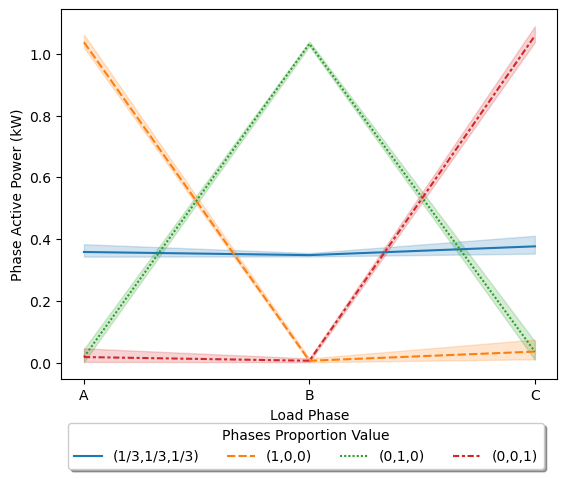

In [15]:
sns.lineplot(sensitivity_analysis_2_df[sensitivity_analysis_2_df.power_type=='p'],x='phase',y='value',hue='phases_proportion_value',style='phases_proportion_value')

plt.ylabel('Phase Active Power (kW)')
plt.xlabel('Load Phase')
plt.xticks([0,1,2],['A','B','C'])
plt.legend(loc=2,bbox_to_anchor=(0,-0.1),
          fancybox=True, shadow=True, ncol=4,title='Phases Proportion Value')



# Sensitivity Analysis part 3: phases_choice

to do


In [33]:


phases_choice_list=[[1/3,1/3,1/3],
                        [1,0,0],
                        [0,1,0],
                        [0,0,1]]
mean_error_dict={}
power_data_df_dict={}


for phases_choice_idx in range(len(phases_choice_list)):
    print('######################## {} #####################'.format(phases_choice_idx))
    mean_error_dict[phases_choice_idx]={}
    for bus in node_list:
        aggregated_power_dict[bus]=individual_aggregated_power
        phases_proportion[bus][:]=[1/3,1/3,1/3]
        p_phases_choice[bus][:]=phases_choice_list[phases_choice_idx]
        #prob_three_phases_dict[bus]=priori_prop_three_phase_dict[bus]
        prob_three_phases_dict[bus]=0

    three_phase_model=generate_3_phase_model(graph_from_net,aggregated_power_dict,prob_three_phases_dict,phases_proportion,p_phases_choice)

    [power_data_df,error_dict]=generate_power_data_df(three_phase_model)

    for key in error_dict.keys():
        mean_error_dict[phases_choice_idx][key]=np.mean(error_dict[key])
        power_data_df_dict[phases_choice_idx]=copy.deepcopy(power_data_df)




######################## 0 #####################


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 210 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


0
1
2
3


Only 100 samples in chain.


######################## 1 #####################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 155 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


Only 100 samples in chain.


######################## 2 #####################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 212 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


Only 100 samples in chain.


######################## 3 #####################


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 10 tune and 100 draw iterations (40 + 400 draws total) took 230 seconds.
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


0
1
2
3


In [16]:
to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\results\changing_phases_choice'

#pickle.dump(mean_error_dict,open(os.path.join(to_save_folder,'mean_error_dict.pickle'),'wb'))

#pickle.dump(power_data_df_dict,open(os.path.join(to_save_folder,'power_data_df_dict.pickle'),'wb'))

mean_error_dict=pickle.load(open(os.path.join(to_save_folder,'mean_error_dict.pickle'),'rb'))

power_data_df_dict=pickle.load(open(os.path.join(to_save_folder,'power_data_df_dict.pickle'),'rb'))

In [17]:
power_data_df_dict

{}

In [24]:
phases_choice_str_list=['(1/3,1/3,1/3)',
                            '(1,0,0)',
                            '(0,1,0)',
                            '(0,0,1)']

In [ ]:
sensitivity_analysis_3_df=pd.DataFrame(columns=['phases_choice_value','power_type','phase','value'])

for phases_choice_idx in range(len(phases_choice_list)):
    phases_choice=phases_choice_str_list[phases_choice_idx]
    power_data_df=power_data_df_dict_3[phases_choice_idx]

    for df_idx in power_data_df.index:
        power_type=power_data_df.at[df_idx,'power_type']
        phase=power_data_df.at[df_idx,'phase']
        phase_translation_dict={'a':0,
                                'b':2,
                                'c':1}

        value=power_data_df.at[df_idx,'value']

        if(power_type=='p'):
            sensitivity_analysis_3_df.loc[len(sensitivity_analysis_3_df)]=[phases_choice,power_type,phase_translation_dict[phase],value]

KeyError: 0

In [163]:
sensitivity_analysis_2_df.head()

,phases_proportion_value,power_type,phase,value
0,"(1/3,1/3,1/3)",p,0,0.351508
1,"(1/3,1/3,1/3)",p,1,0.354245
2,"(1/3,1/3,1/3)",p,2,0.353252
3,"(1/3,1/3,1/3)",p,0,0.349238
4,"(1/3,1/3,1/3)",p,1,0.349637


In [162]:
sensitivity_analysis_3_df.head()

,phases_choice_value,power_type,phase,value
0,"(1/3,1/3,1/3)",p,0,0.335545
1,"(1/3,1/3,1/3)",p,1,0.362035
2,"(1/3,1/3,1/3)",p,2,0.344805
3,"(1/3,1/3,1/3)",p,0,0.329211
4,"(1/3,1/3,1/3)",p,1,0.378249


TypeError: Axes.bxp() got an unexpected keyword argument 'style'

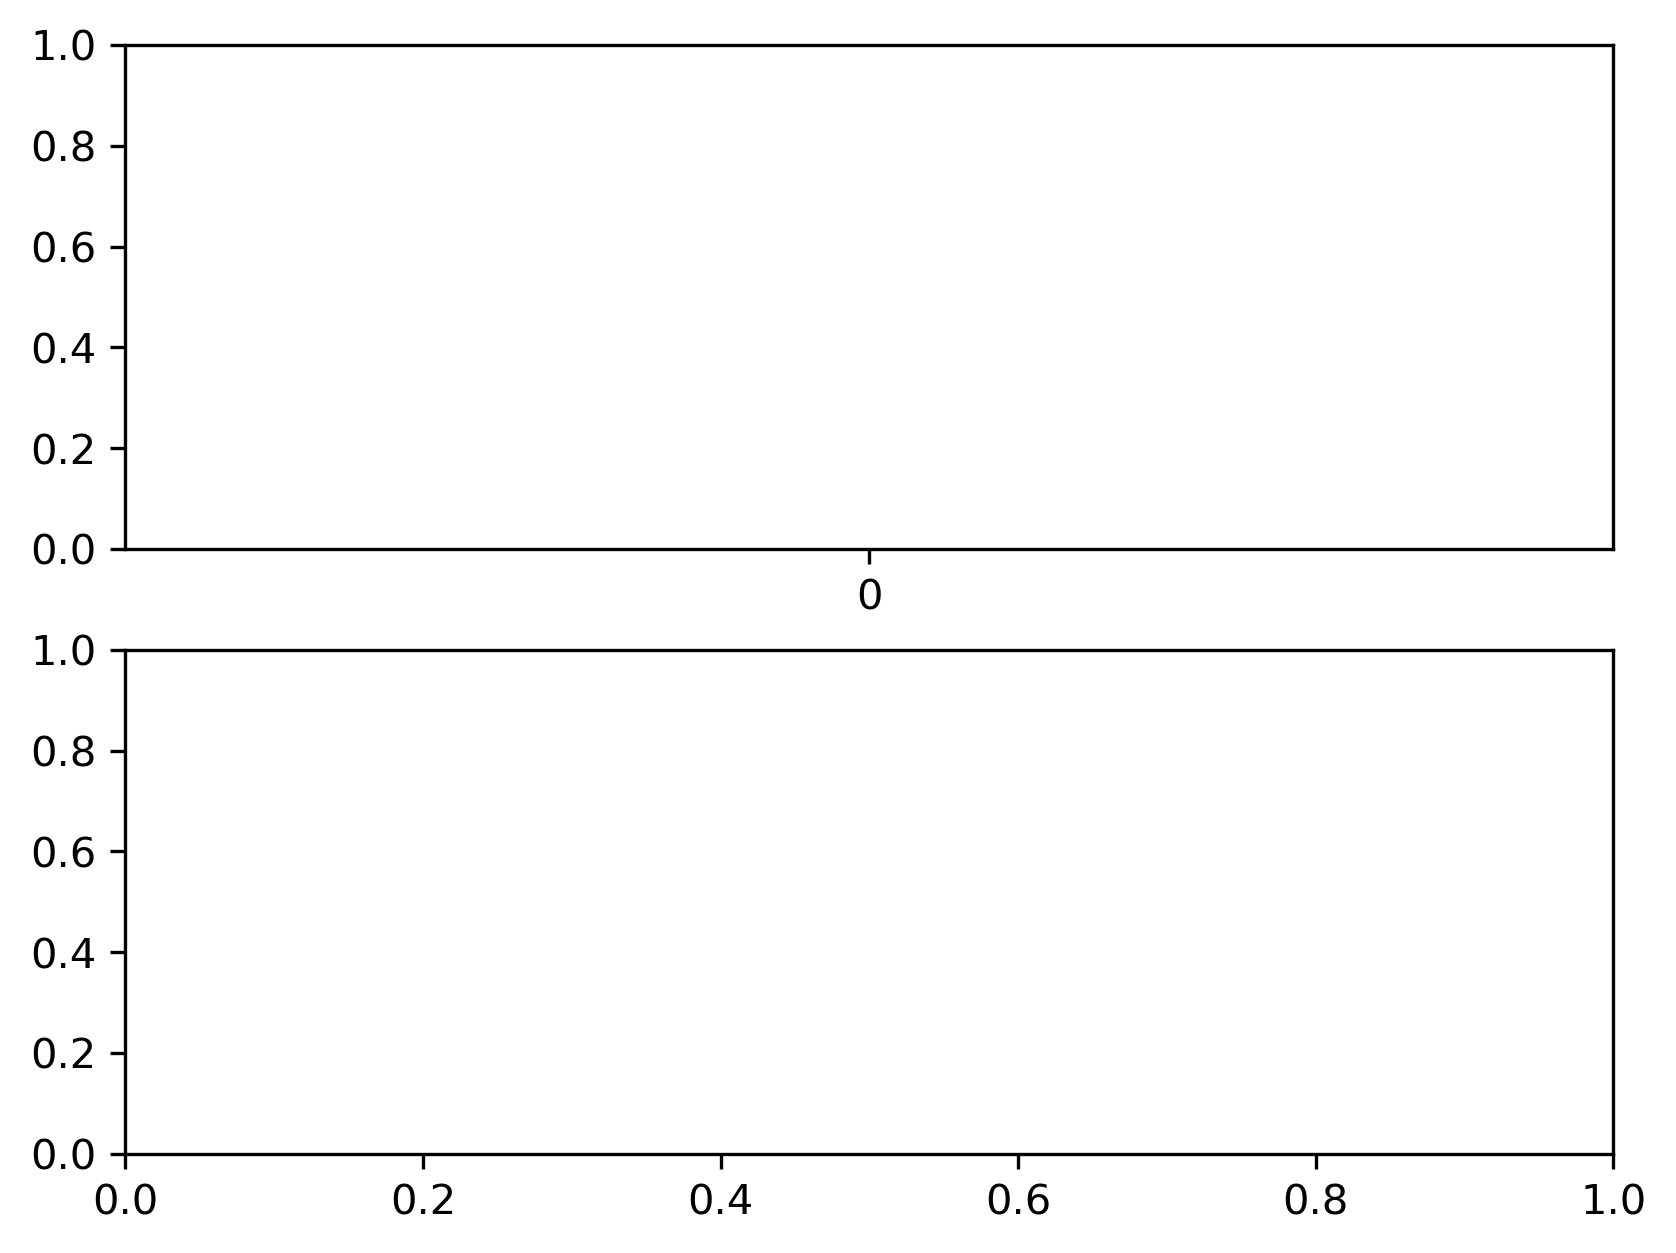

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
fig,axs=plt.subplots(2,1)


sns.lineplot(sensitivity_analysis_2_df[sensitivity_analysis_2_df.power_type=='p'],x='phase',y='value',hue='phases_proportion_value',style='phases_proportion_value',ax=axs[0],legend=False)
axs[0].set_ylabel('Phase Active Power (kW)')
axs[0].set_xlabel('Load Phase')
axs[0].set_xticks([0,1,2],['A','B','C'])
axs[0].set_title('Phases Proportion')

sns.lineplot(sensitivity_analysis_2_df[sensitivity_analysis_2_df.power_type=='p'],x='phase',y='value',hue='phases_proportion_value',style='phases_proportion_value',ax=axs[1],legend=False)
axs[1].set_ylabel('Phase Active Power (kW)')
axs[1].set_xlabel('Load Phase')
axs[1].set_xticks([0,1,2],['A','B','C'])
axs[1].set_title('Phases Choice')

#sns.lineplot(sensitivity_analysis_3_df[sensitivity_analysis_3_df.power_type=='p'],x='phase',y='value',hue='phases_choice_value',style='phases_choice_value',ax=axs[1],legend=True)
#axs[1].set_ylabel('Phase Active Power (kW)')
#axs[1].set_xlabel('Load Phase')
#axs[1].set_xticks([0,1,2],['A','B','C'])
#axs[1].set_title('Phases Choice')
plt.legend(loc=2,bbox_to_anchor=(0.05,-0.3),
         fancybox=True, shadow=True, ncol=4,title='Categorical Probabilities')

plt.tight_layout()


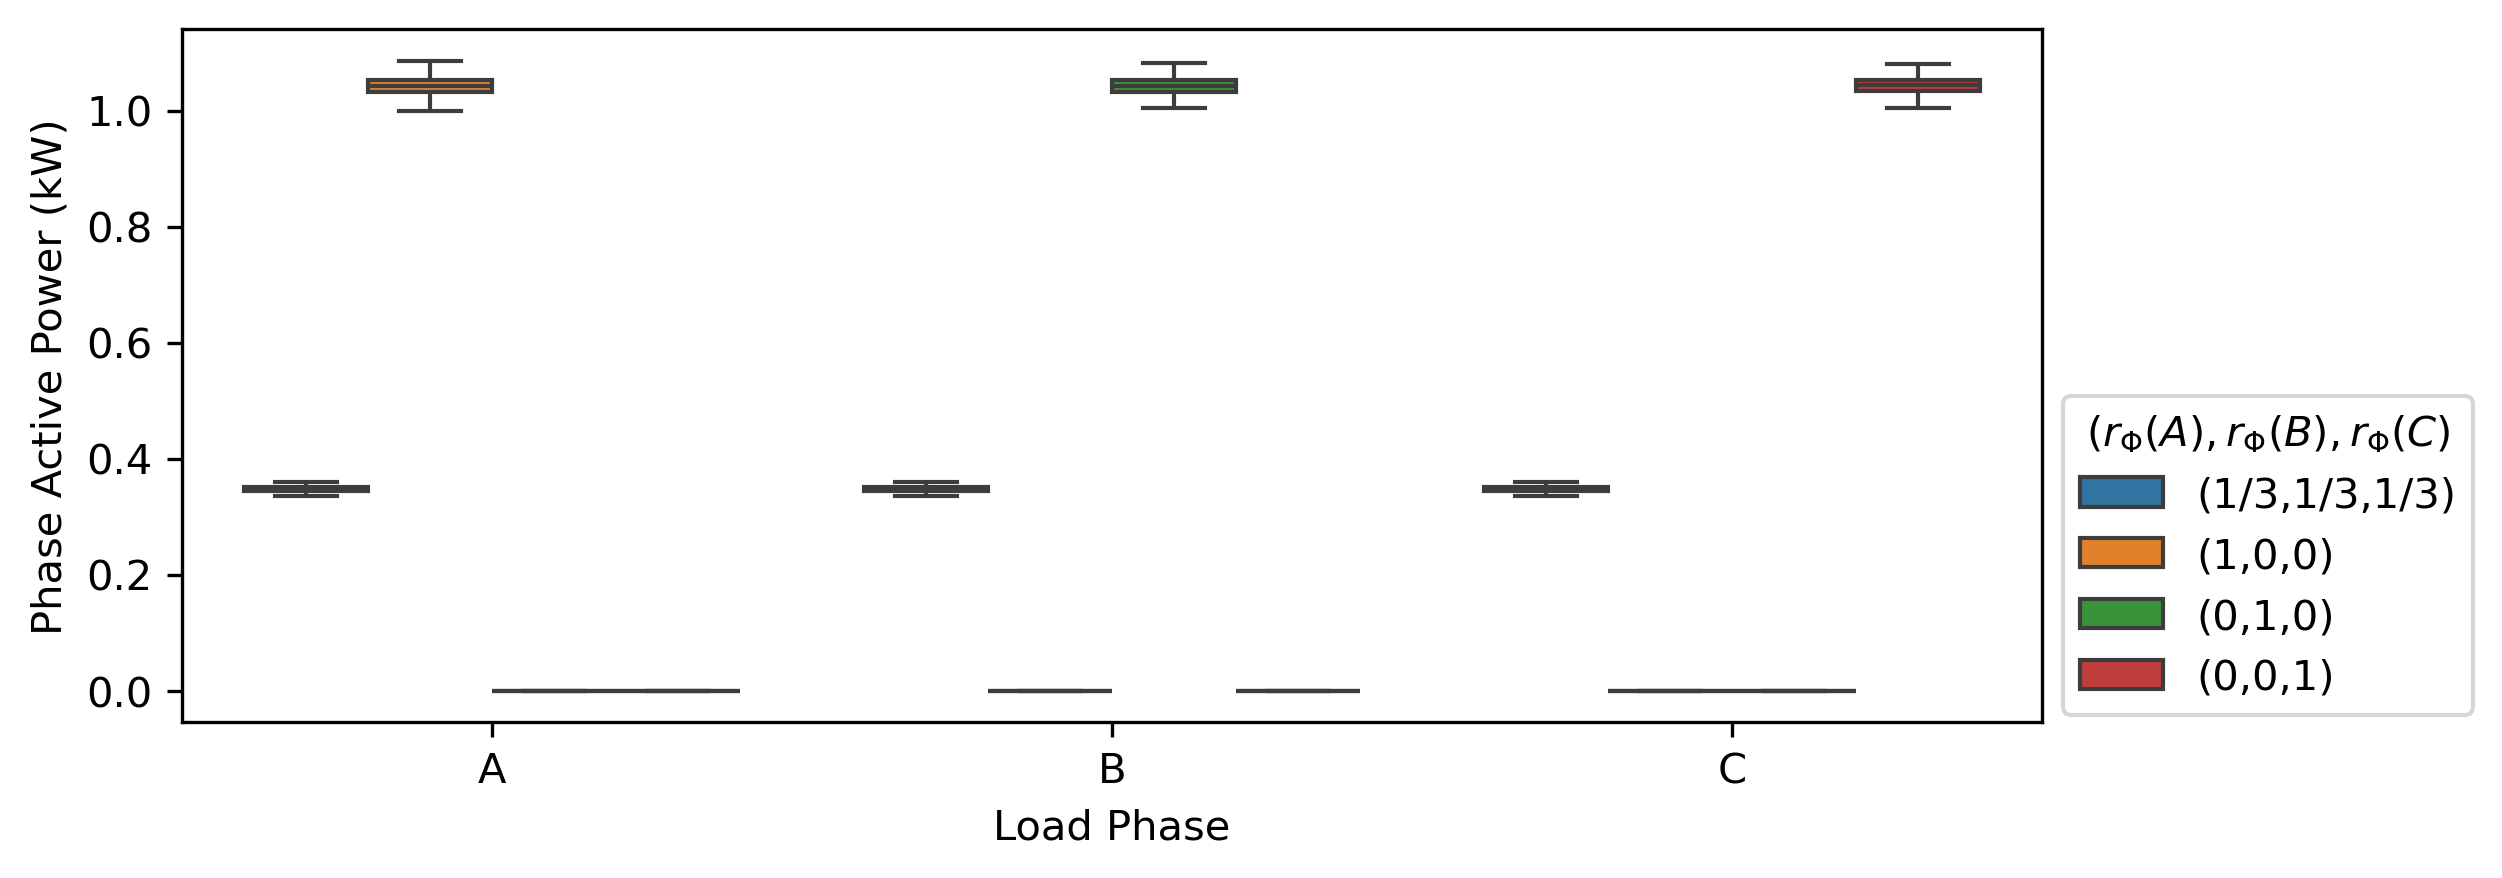

In [124]:
mpl.rc('figure', figsize=(8, 3))

sns.boxplot(sensitivity_analysis_2_df[sensitivity_analysis_2_df.power_type=='p'],x='phase',y='value',hue='phases_proportion_value',legend=True,showfliers=False)
plt.ylabel('Phase Active Power (kW)')
plt.xlabel('Load Phase')
plt.xticks([0,1,2],['A','B','C'])
plt.legend(ncol=1,title=r'$(r_{\Phi}(A),r_{\Phi}(B),r_{\Phi}(C)$',bbox_to_anchor=(1, 0.5))

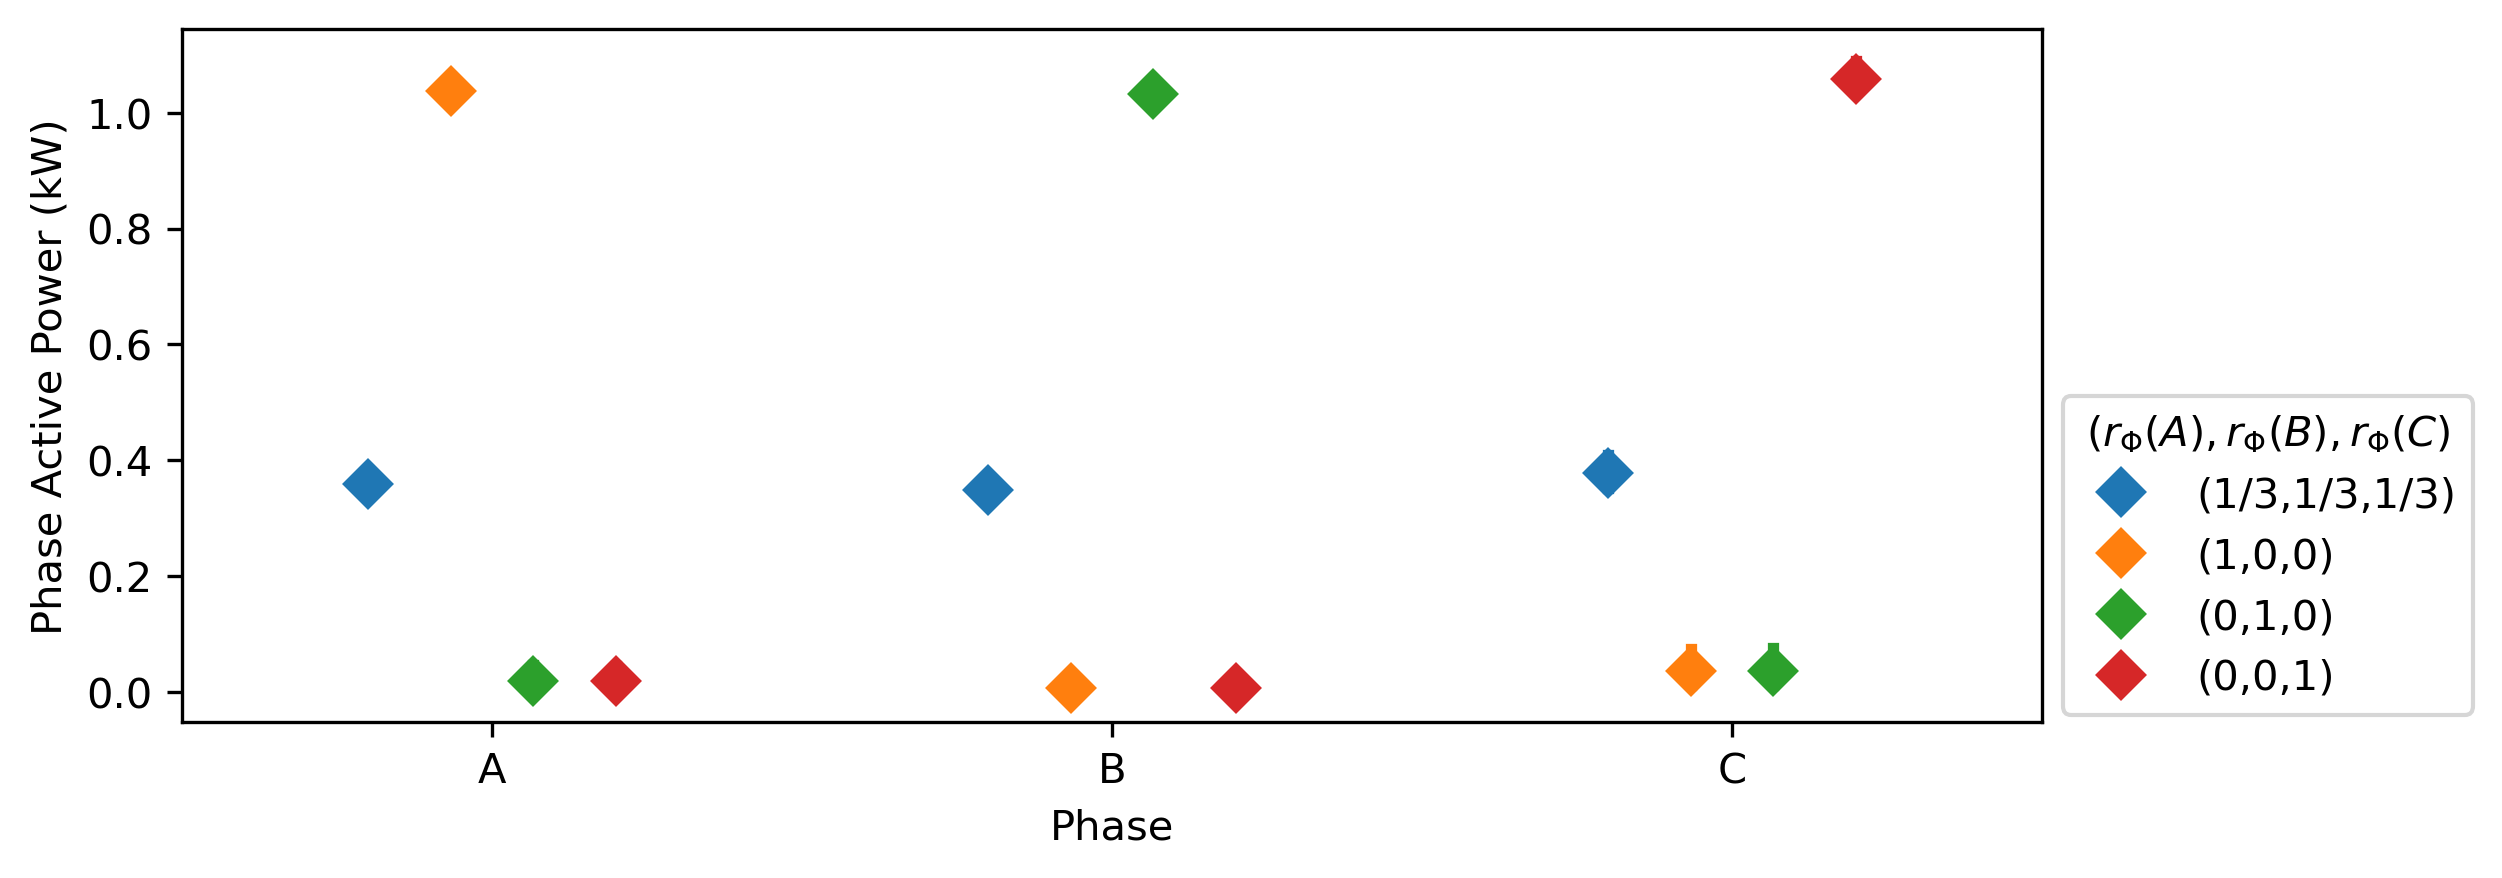

In [134]:
mpl.rc('figure', figsize=(8, 3))

sns.pointplot(sensitivity_analysis_2_df[sensitivity_analysis_2_df.power_type=='p'],x='phase',y='value',hue='phases_proportion_value',legend=True,marker="D",
              linestyle='none',dodge=.4)
plt.ylabel('Phase Active Power (kW)')
plt.xlabel('Phase')
plt.xticks([0,1,2],['A','B','C'])
plt.legend(ncol=1,title=r'$(r_{\Phi}(A),r_{\Phi}(B),r_{\Phi}(C)$',bbox_to_anchor=(1, 0.5))

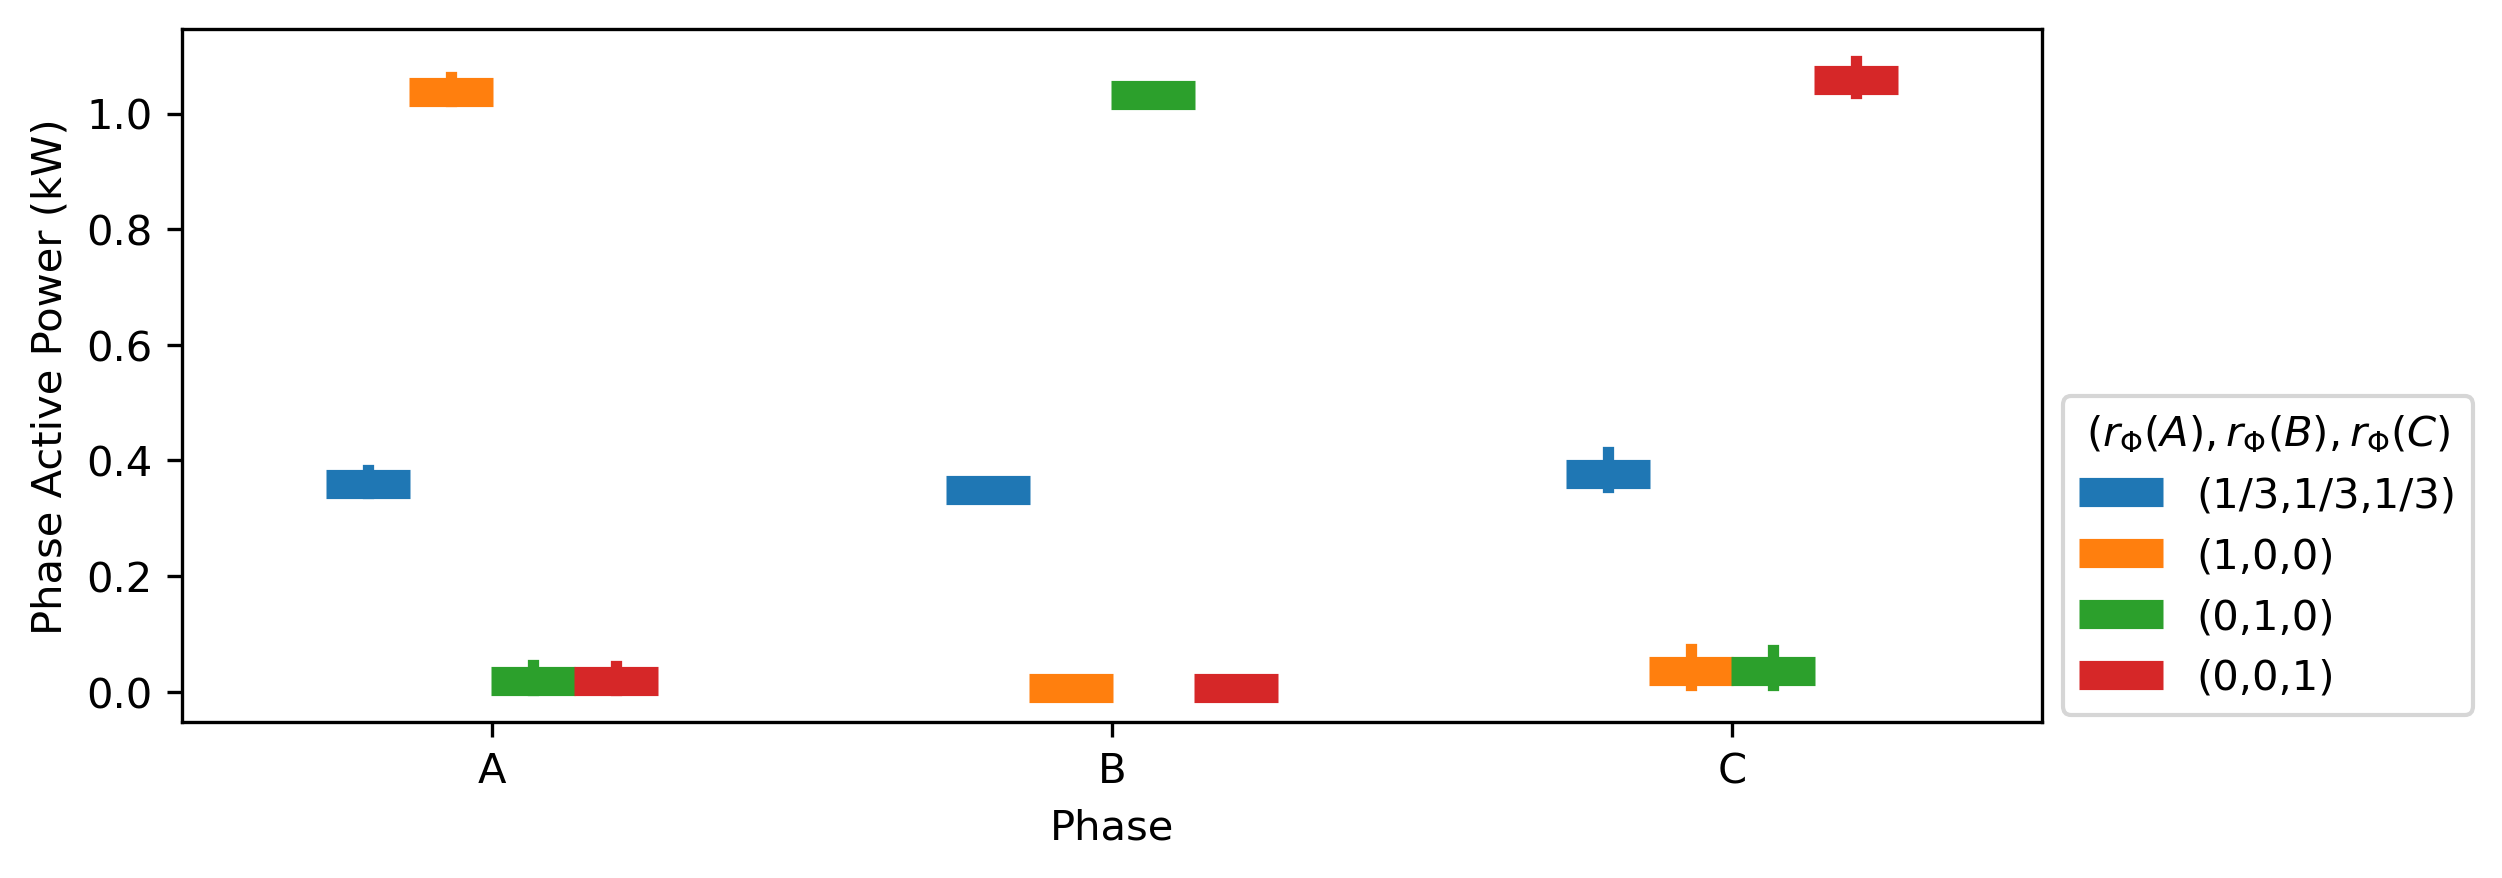

In [149]:
mpl.rc('figure', figsize=(8, 3))

sns.pointplot(sensitivity_analysis_2_df[sensitivity_analysis_2_df.power_type=='p'],x='phase',y='value',hue='phases_proportion_value',legend=True,
              linestyle='none',dodge=.4,
              marker="_", markersize=20, markeredgewidth=7)
plt.ylabel('Phase Active Power (kW)')
plt.xlabel('Phase')
plt.xticks([0,1,2],['A','B','C'])
plt.legend(ncol=1,title=r'$(r_{\Phi}(A),r_{\Phi}(B),r_{\Phi}(C)$',bbox_to_anchor=(1, 0.5))